# Implementing semantic video search in 5 minutes using CLIP

We'll implement a **naive** semantic video search using OpenAI's [CLIP](https://github.com/openai/CLIP) model (ignoring audio) in Python.

(Scroll down if you want to skip to the results. GitHub repo for this [here](https://github.com/sradc/semantic-video-search).)

In [ ]:
from pathlib import Path

import clip
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from PIL import Image
from tqdm import tqdm

sns.set_theme()
torch.set_printoptions(sci_mode=False)

In [2]:
data_dir = Path("data_dir")
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)  # will download ~340mb model

## Use [CLIP](https://github.com/openai/CLIP) to encode images and text into the same vector space

- CLIP can take an image and turn it into a vector of size 512
- CLIP can take a piece of text and turn it into a vector of size 512
- If the text and image are similar, their vectors will be "similar" 
    - (via cosine similarity - i.e. the vectors should be pointing in a similar direction)
- Here's an example:

### Turn an image and some pieces of text into vectors:

In [3]:
image = preprocess(Image.open("dog.jpeg")).unsqueeze(0).to(device)
dog_text = clip.tokenize(["a photo of a dog"]).to(device)
cat_text = clip.tokenize(["a photo of a cat"]).to(device)
misc_text = clip.tokenize(["red green yellow"]).to(device)
with torch.no_grad():
    image_vector = model.encode_image(image)
    dog_text_vector = model.encode_text(dog_text)
    cat_text_vector = model.encode_text(cat_text)
    misc_text_vector = model.encode_text(misc_text)
print(f"{image_vector.shape = }")
print(f"{dog_text_vector.shape = }")
print(f"{cat_text_vector.shape = }")
print(f"{misc_text_vector.shape = }")

image_vector.shape = torch.Size([1, 512])
dog_text_vector.shape = torch.Size([1, 512])
cat_text_vector.shape = torch.Size([1, 512])
misc_text_vector.shape = torch.Size([1, 512])


In [4]:
dog_similarity = torch.cosine_similarity(image_vector, dog_text_vector).item()
cat_similarity = torch.cosine_similarity(image_vector, cat_text_vector).item()
misc_similarity = torch.cosine_similarity(image_vector, misc_text_vector).item()
print(f"dog similarity: {dog_similarity:.2f}")
print(f"cat similarity: {cat_similarity:.2f}")
print(f"misc similarity: {misc_similarity:.2f}")

dog similarity: 0.28
cat similarity: 0.20
misc similarity: 0.20


Note that dog has the highest value, which is what we would hope for since the image is of a dog. 

But do the cat and misc values seem low enough compared to the dog value?

Well, looking at the [CLIP codebase](https://github.com/openai/CLIP/blob/d50d76daa670286dd6cacf3bcd80b5e4823fc8e1/clip/model.py#L367) we can see that softmax with a temperature parameter (i.e. `logit_scale`) is used on the cosine similarities, like this:

In [5]:
logit_scale = model.logit_scale.exp().item()
distances = logit_scale * torch.tensor(
    [dog_similarity, cat_similarity, misc_similarity]
)
softmaxed_distances = distances.exp() / distances.exp().sum()
print(f"{logit_scale = }")
print(f"{softmaxed_distances = }")
for x, distance in zip(["dog", "cat", "misc"], softmaxed_distances):
    print(f"{x} similarity: {distance.item():.4f}")

logit_scale = 100.0
softmaxed_distances = tensor([    0.9990,     0.0005,     0.0005])
dog similarity: 0.9990
cat similarity: 0.0005
misc similarity: 0.0005


So we can see that the model is pretty certain that "a photo of a dog" is the best of the options it was presented with to describe the image.

Note that we don't actually need to do this softmax stuff, since we just care about the max value, which is preserved, (e.g. the dog was still the max value before the softmax) - but it helps makes the results more interpretable.

Now, how could we use this technology to carry out semantic search over video?...

## Download a video

We'll grab a video that has varied visual content (since we're ignoring audio). (It's a compilation of Buster Keaton stunts, check it [out](https://www.youtube.com/watch?v=frYIj2FGmMA).)

In [6]:
video_path = data_dir / 'buster_keaton.mp4'
if not video_path.is_file():
    !yt-dlp -f 133 -o {video_path}  \
        'https://www.youtube.com/watch?v=frYIj2FGmMA'

## Convert the video into CLIP vectors

Use [OpenCV](https://opencv.org/) (cv2) to process the video.

In [7]:
cap = cv2.VideoCapture(str(video_path))
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
fps = int(cap.get(cv2.CAP_PROP_FPS))
print(f"{frame_count = }")
print(f"{fps = }")
print(
    f"video size: {cap.get(cv2.CAP_PROP_FRAME_WIDTH):.0f}w {cap.get(cv2.CAP_PROP_FRAME_HEIGHT):.0f}h"
)

frame_count = 7465
fps = 24
video size: 426w 240h


Iterate through all frames in the video, and convert them into CLIP vectors:

In [8]:
image_vectors = torch.zeros((frame_count, 512), device=device)
for i in tqdm(range(frame_count)):
    ret, frame = cap.read()
    with torch.no_grad():
        image_vectors[i] = model.encode_image(
            preprocess(Image.fromarray(frame)).unsqueeze(0).to(device)
        )

100%|██████████| 7465/7465 [01:17<00:00, 96.33it/s] 


Most of the work was done here.

Next we create a function that will convert a "query" (i.e. a piece of text) into a vector, and look for the most similar video frames.

In [9]:
def get_most_similar_frame(query: str) -> tuple[int, list[float]]:
    query_vector = model.encode_text(clip.tokenize([query]).to(device))
    similarities = torch.cosine_similarity(image_vectors, query_vector)
    index = similarities.argmax().item()
    return index, similarities.squeeze()


def display_frame(index: int):
    cap.set(cv2.CAP_PROP_POS_FRAMES, index)
    ret, frame = cap.read()
    display(Image.fromarray(frame))


def plot_search(query, similarities):
    plt.figure(figsize=(8, 4))
    plt.plot((logit_scale * similarities).softmax(dim=0).tolist())
    plt.title(f"Search of video frames for '{query}'")
    plt.xlabel("Frame number")
    plt.ylabel("Query-frame similarity (softmaxed)")
    plt.show()

## Results

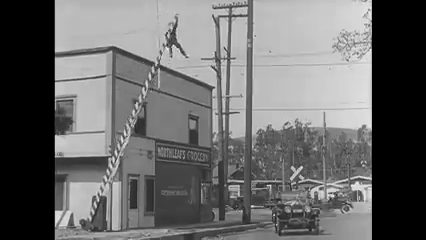

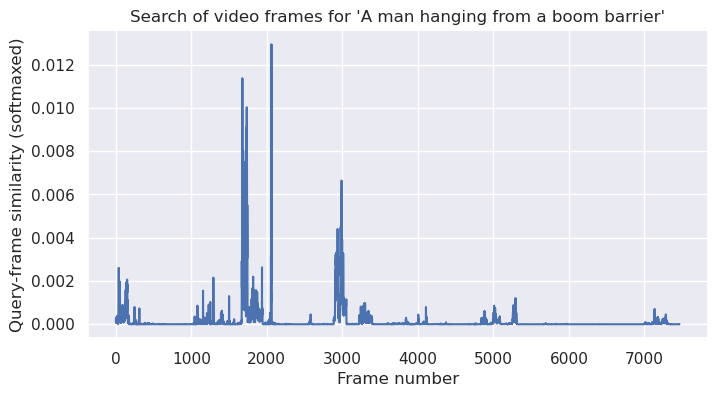

In [10]:
query = "A man hanging from a boom barrier"
frame, similarities = get_most_similar_frame(query)
display_frame(frame)
plot_search(query, similarities)

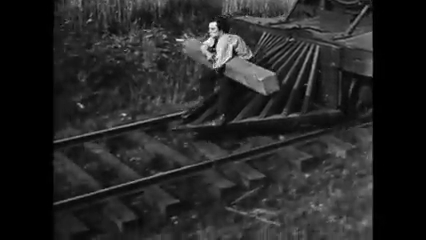

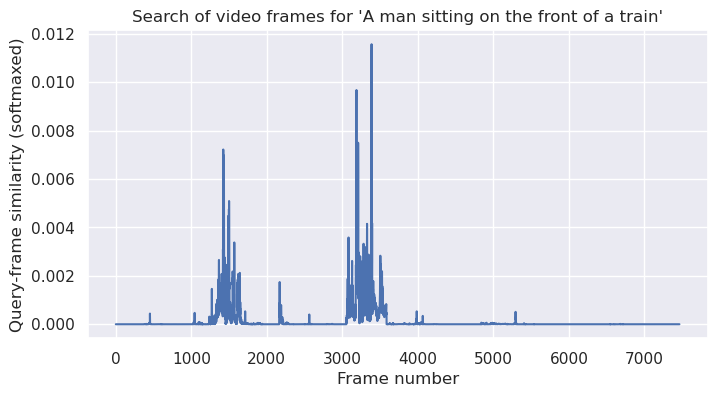

In [11]:
query = "A man sitting on the front of a train"
frame, similarities = get_most_similar_frame(query)
display_frame(frame)
plot_search(query, similarities)

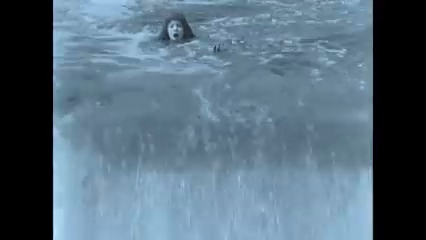

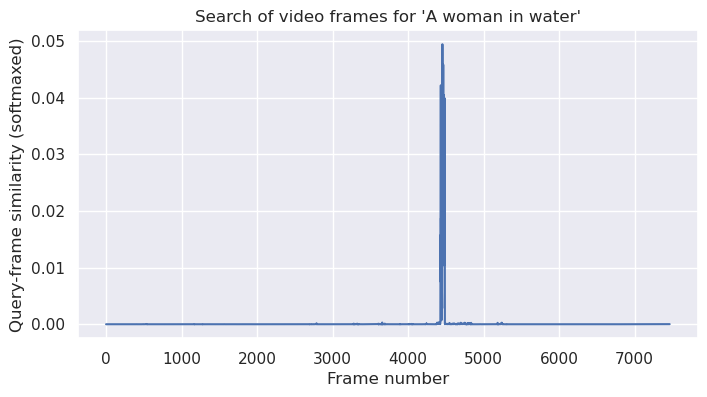

In [12]:
query = "A woman in water"
frame, similarities = get_most_similar_frame(query)
display_frame(frame)
plot_search(query, similarities)

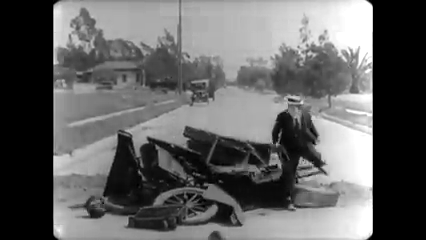

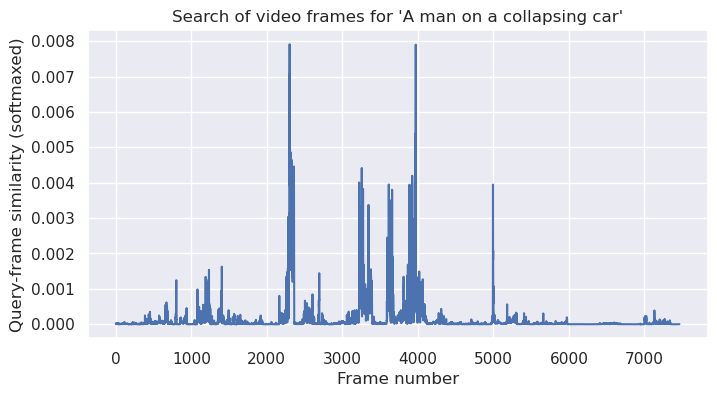

In [13]:
query = "A man on a collapsing car"
frame, similarities = get_most_similar_frame(query)
display_frame(frame)
plot_search(query, similarities)

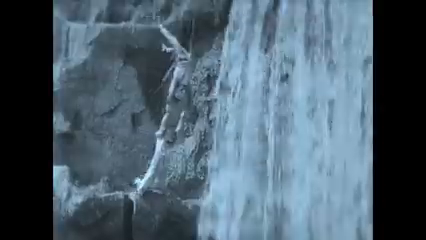

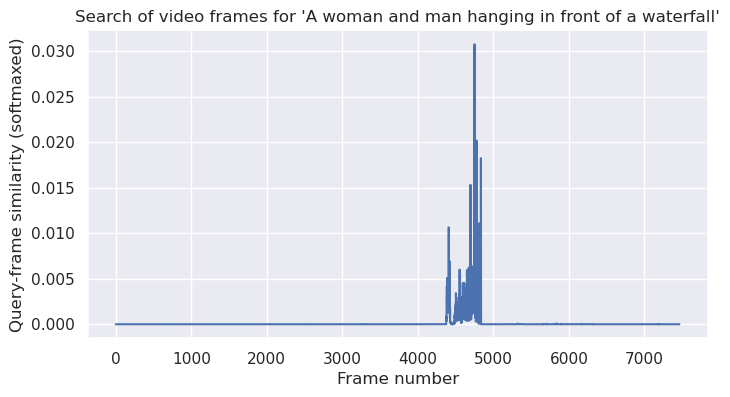

In [14]:
query = "A woman and man hanging in front of a waterfall"
frame, similarities = get_most_similar_frame(query)
display_frame(frame)
plot_search(query, similarities)

There's a lot of room for improvement,
but this naive approach takes us surprisingly far... 
(well, perhaps not surprisingly, considering that we're making 
heavy use of an incredible piece of technology, CLIP).

Improvements (just throwing out ideas):
- Batch encode video frames for a speed up
- Skip very similar video frames (before and/or after embedding)
- Use fast vector similarity search tooling, e.g. [faiss](https://github.com/facebookresearch/faiss)
- Better embedding model is an option (e.g. a larger clip model)
- Provide top K results (could enforce some level of diversity/use peaks that are distanced over time)
- And plenty more... 

This was a fun POC, and it's so awesome that models like CLIP are available to 
be freely used, so thanks to those involved for that!